## Decision Trees and Random Forests



![](https://i.imgur.com/N8aIuRK.jpg)

The following topics are covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting & hyperparameter tuning
- Making predictions on single inputs



## Problem Statement & data prep



This tutorial takes a practical and coding-focused approach. We'll learn how to use _decision trees_ and _random forests_ to solve a real-world problem from [Kaggle](https://kaggle.com/datasets):

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:
> 
> ![](https://i.imgur.com/5QNJvir.png)
>
> As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow. 
>
>
> ![](https://i.imgur.com/KWfcpcO.png)


Let's install and import some required libraries before we begin.

In [1]:
#restart the kernel after installation
%pip install numpy matplotlib seaborn scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
raw_df = pd.read_csv("https://www.kaggle.com/api/v1/datasets/download/jsphyg/weather-dataset-rattle-package", compression="zip"); raw_df


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


## Preprocessing

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

#%% Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ],
    sparse_threshold=0
    )
preprocessor.set_output(transform="pandas")

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002418159D2B0>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000024181571090>)])

In [5]:
#%% Split the data into train and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

input_cols = list(raw_df.drop(['Date', 'RainTomorrow'], axis=1).columns)
target_col = 'RainTomorrow'

X_train, y_train = preprocessor.fit_transform(train_df[input_cols], train_df[target_col]), train_df[target_col].copy()
X_val,   y_val   = preprocessor.transform(val_df[input_cols]),                            val_df[target_col].copy()
X_test,  y_test  = preprocessor.transform(test_df[input_cols]),                           test_df[target_col].copy()
X_train

,num__MinTemp,num__MaxTemp,num__Rainfall,num__Evaporation,num__Sunshine,num__WindGustSpeed,num__WindSpeed9am,num__WindSpeed3pm,num__Humidity9am,num__Humidity3pm,num__Pressure9am,num__Pressure3pm,num__Cloud9am,num__Cloud3pm,num__Temp9am,num__Temp3pm,cat__Location_Adelaide,cat__Location_Albany,cat__Location_Albury,cat__Location_AliceSprings,cat__Location_BadgerysCreek,cat__Location_Ballarat,cat__Location_Bendigo,cat__Location_Brisbane,cat__Location_Cairns,cat__Location_Canberra,cat__Location_Cobar,cat__Location_CoffsHarbour,cat__Location_Dartmoor,cat__Location_Darwin,cat__Location_GoldCoast,cat__Location_Hobart,cat__Location_Katherine,cat__Location_Launceston,cat__Location_Melbourne,cat__Location_MelbourneAirport,cat__Location_Mildura,cat__Location_Moree,cat__Location_MountGambier,cat__Location_MountGinini,cat__Location_Newcastle,cat__Location_Nhil,cat__Location_NorahHead,cat__Location_NorfolkIsland,cat__Location_Nuriootpa,cat__Location_PearceRAAF,cat__Location_Penrith,cat__Location_Perth,cat__Location_PerthAirport,cat__Location_Portland,cat__Location_Richmond,cat__Location_Sale,cat__Location_SalmonGums,cat__Location_Sydney,cat__Location_SydneyAirport,cat__Location_Townsville,cat__Location_Tuggeranong,cat__Location_Uluru,cat__Location_WaggaWagga,cat__Location_Walpole,cat__Location_Watsonia,cat__Location_Williamtown,cat__Location_Witchcliffe,cat__Location_Wollongong,cat__Location_Woomera,cat__WindGustDir_E,cat__WindGustDir_ENE,cat__WindGustDir_ESE,cat__WindGustDir_N,cat__WindGustDir_NE,cat__WindGustDir_NNE,cat__WindGustDir_NNW,cat__WindGustDir_NW,cat__WindGustDir_S,cat__WindGustDir_SE,cat__WindGustDir_SSE,cat__WindGustDir_SSW,cat__WindGustDir_SW,cat__WindGustDir_W,cat__WindGustDir_WNW,cat__WindGustDir_WSW,cat__WindGustDir_missing,cat__WindDir9am_E,cat__WindDir9am_ENE,cat__WindDir9am_ESE,cat__WindDir9am_N,cat__WindDir9am_NE,cat__WindDir9am_NNE,cat__WindDir9am_NNW,cat__WindDir9am_NW,cat__WindDir9am_S,cat__WindDir9am_SE,cat__WindDir9am_SSE,cat__WindDir9am_SSW,cat__WindDir9am_SW,cat__WindDir9am_W,cat__WindDir9am_WNW,cat__WindDir9am_WSW,cat__WindDir9am_missing,cat__WindDir3pm_E,cat__WindDir3pm_ENE,cat__WindDir3pm_ESE,cat__WindDir3pm_N,cat__WindDir3pm_NE,cat__WindDir3pm_NNE,cat__WindDir3pm_NNW,cat__WindDir3pm_NW,cat__WindDir3pm_S,cat__WindDir3pm_SE,cat__WindDir3pm_SSE,cat__WindDir3pm_SSW,cat__WindDir3pm_SW,cat__WindDir3pm_W,cat__WindDir3pm_WNW,cat__WindDir3pm_WSW,cat__WindDir3pm_missing,cat__RainToday_No,cat__RainToday_Yes
0,0.516509,0.517241,0.001617,0.064199,0.532098,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490075,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.375000,0.559387,0.000000,0.064199,0.532098,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478106,0.490075,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.504717,0.570881,0.000000,0.064199,0.532098,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478106,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Training and Visualizing Decision Trees



A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [6]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)

%time model.fit(X_train, y_train)

CPU times: total: 1.27 s
Wall time: 3.05 s


DecisionTreeClassifier(random_state=42)

An optimal decision tree has now been created using the training data.

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix
train_preds = model.predict(X_train); train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [8]:
pd.Series(train_preds).value_counts()

No     76192
Yes    21796
Name: count, dtype: int64

The decision tree also returns probabilities for each prediction.

In [9]:
model.predict_proba(X_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [10]:
accuracy_score(y_train, train_preds)

0.9999795893374699

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [11]:
model.score(X_val, y_val)

0.7935514073380537

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [12]:
y_val.value_counts() / len(y_val)

RainTomorrow
No     0.790626
Yes    0.209374
Name: count, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [13]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns,  filledmax_depth=3,=True);

SyntaxError: invalid syntax (2117040138.py, line 3)

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://i.imgur.com/tlYiXnp.png" width="480">


Let's check the depth of the tree that was created.

In [ ]:
model.tree_.max_depth

We can also display the tree as text, which can be easier to follow for deeper trees.

In [ ]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

> **EXERCISE**: Based on the above discussion, can you explain why the training accuracy is 100% whereas the validation accuracy is lower?

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [ ]:
model.feature_importances_

Let's turn this into a dataframe and visualize the most important features.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df

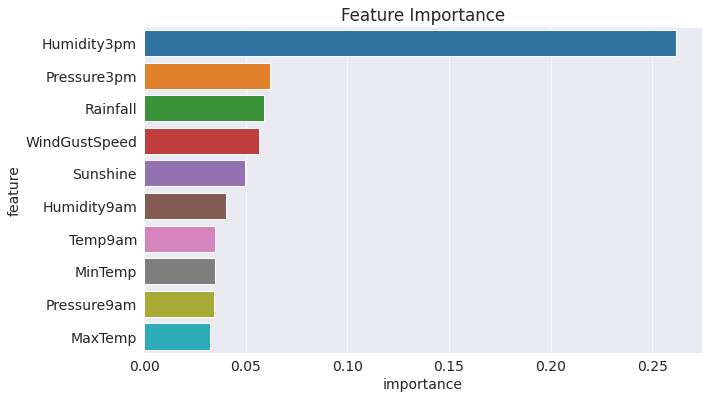

In [58]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting



As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. 


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [67]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [89]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [73]:
model.score(X_train, y_train)

0.8315916234640977

In [75]:
model.score(X_val, y_val)

0.8348060155655685

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

In [76]:
model.classes_

array(['No', 'Yes'], dtype=object)

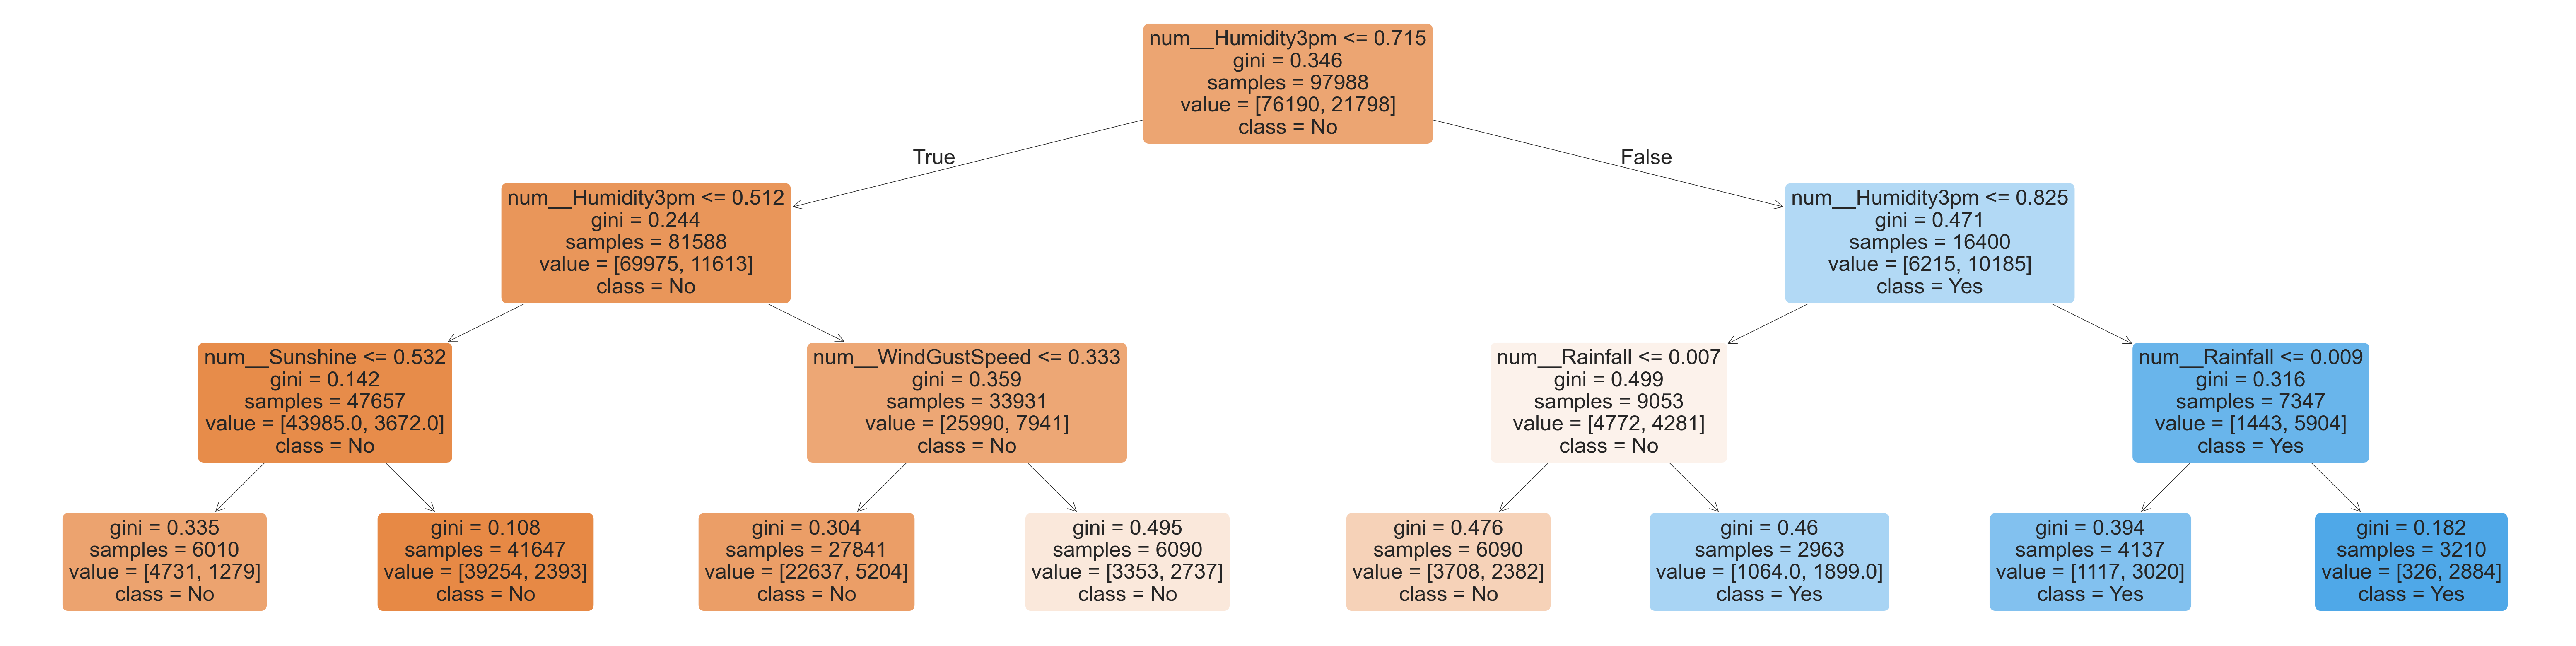

In [78]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

> **EXERCISE**: Study the decision tree diagram carefully and understand what each of the terms `gini`, `samples`, `value` and `class` mean.

In [86]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- num__Humidity3pm <= 0.72
|   |--- num__Humidity3pm <= 0.51
|   |   |--- num__Sunshine <= 0.53
|   |   |   |--- class: No
|   |   |--- num__Sunshine >  0.53
|   |   |   |--- class: No
|   |--- num__Humidity3pm >  0.51
|   |   |--- num__WindGustSpeed <= 0.33
|   |   |   |--- class: No
|   |   |--- num__WindGustSpeed >  0.33
|   |   |   |--- class: No
|--- num__Humidity3pm >  0.72
|   |--- num__Humidity3pm <= 0.82
|   |   |--- num__Rainfall <= 0.01
|   |   |   |--- class: No
|   |   |--- num__Rainfall >  0.01
|   |   |   |--- class: Yes
|   |--- num__Humidity3pm >  0.82
|   |   |--- num__Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- num__Rainfall >  0.01
|   |   |   |--- class: Yes



Let's experiment with different depths using a helper function.

In [88]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_val, y_val)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}
%time errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])
errors_df

CPU times: total: 14.4 s
Wall time: 1min 19s


In [90]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155831
6,7,0.149059,0.154602
7,8,0.144814,0.153842
8,9,0.139384,0.154427
9,10,0.131792,0.155188


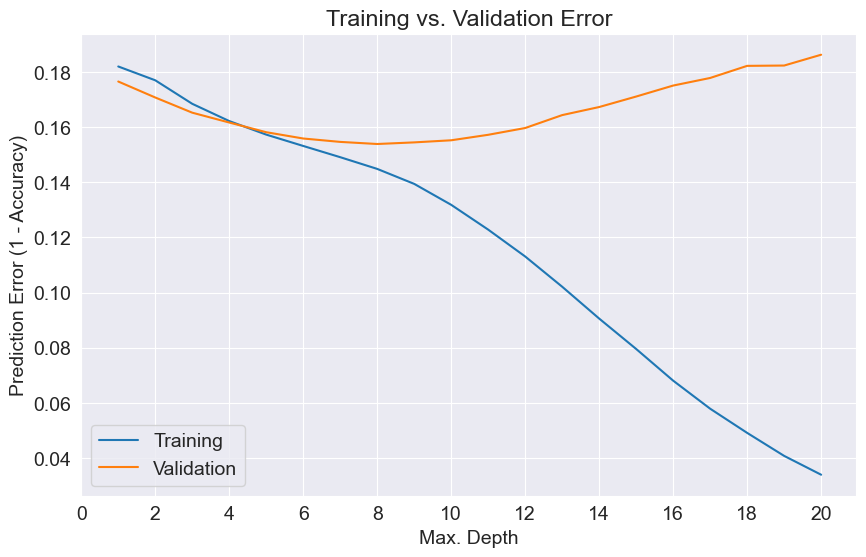

In [91]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">





You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [92]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, y_train)
model.score(X_val, y_val)

0.8453976242027035

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [93]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [94]:
model.score(X_train, y_train)

0.852696248520227

In [95]:
model.score(X_val, y_val)

0.8471531394464276

In [96]:
model.tree_.max_depth

11

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [97]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- num__Humidity3pm <= 0.72
|   |--- num__Humidity3pm <= 0.51
|   |   |--- num__Sunshine <= 0.53
|   |   |   |--- num__Pressure3pm <= 0.57
|   |   |   |   |--- num__Pressure3pm <= 0.42
|   |   |   |   |   |--- num__Humidity3pm <= 0.24
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- num__Humidity3pm >  0.24
|   |   |   |   |   |   |--- num__Sunshine <= 0.37
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- num__Sunshine >  0.37
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- num__Pressure3pm >  0.42
|   |   |   |   |   |--- num__Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- num__Humidity3pm >  0.28
|   |   |   |   |   |   |--- num__Cloud3pm <= 0.39
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- num__Cloud3pm >  0.39
|   |   |   |   |   |   |   |--- cat__Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- num__WindGustSpeed <= 0.23
|   |   |   |   |   |   |   |

> **EXERCISE**: Find the combination of `max_depth` and `max_leaf_nodes` that results in the highest validation accuracy.

> **EXERCISE**: Explore and experiment with other arguments of `DecisionTree`. Refer to the docs for details: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

> **EXERCISE**: A more advanced technique (but less commonly used technique) for reducing overfitting in decision trees is known as cost-complexity pruning. Learn more about it here: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html . Implement cost complexity pruning. Do you see any improvement in the validation accuracy?

## Training a Random Forest



While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.\
`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs = -1, random_state=42)
%time model.fit(X_train, y_train)

CPU times: total: 30.8 s
Wall time: 2.97 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [19]:
model.score(X_train, y_train)

0.9999693840062048

In [20]:
model.score(X_val, y_val)

0.8567499561121189

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [21]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.96, 0.04],
       [0.98, 0.02],
       [0.98, 0.02],
       ...,
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.95, 0.05]])

We can can access individual decision trees using `model.estimators_`

In [22]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

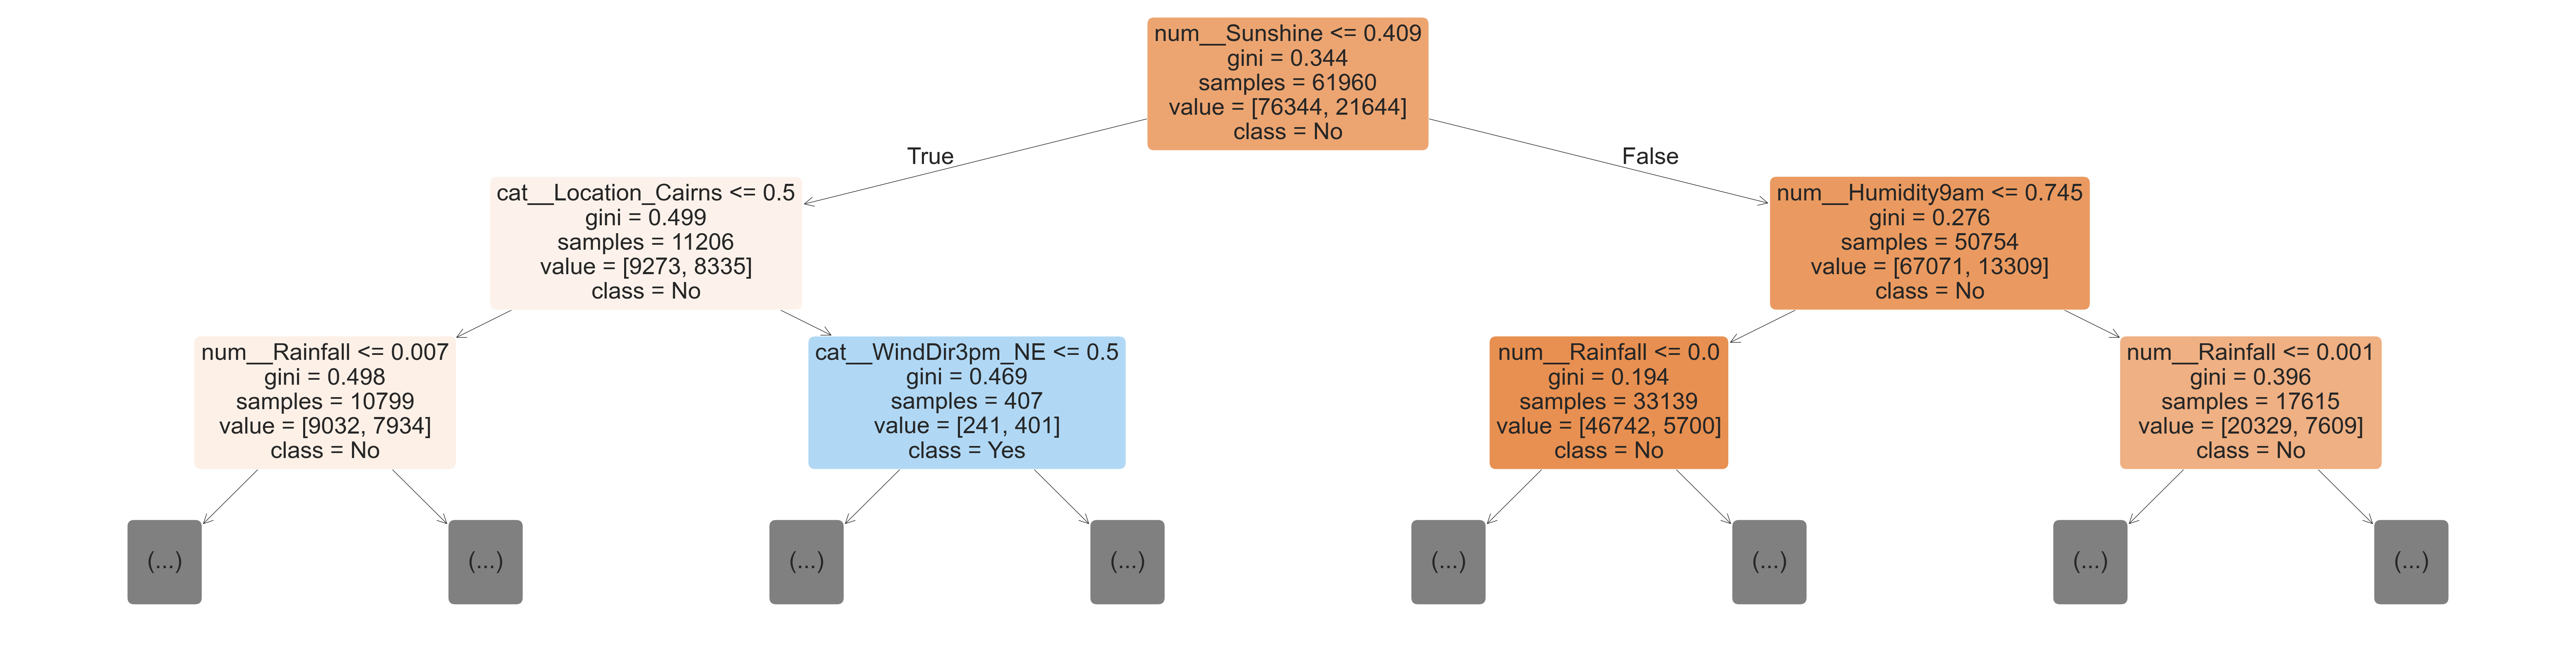

In [23]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

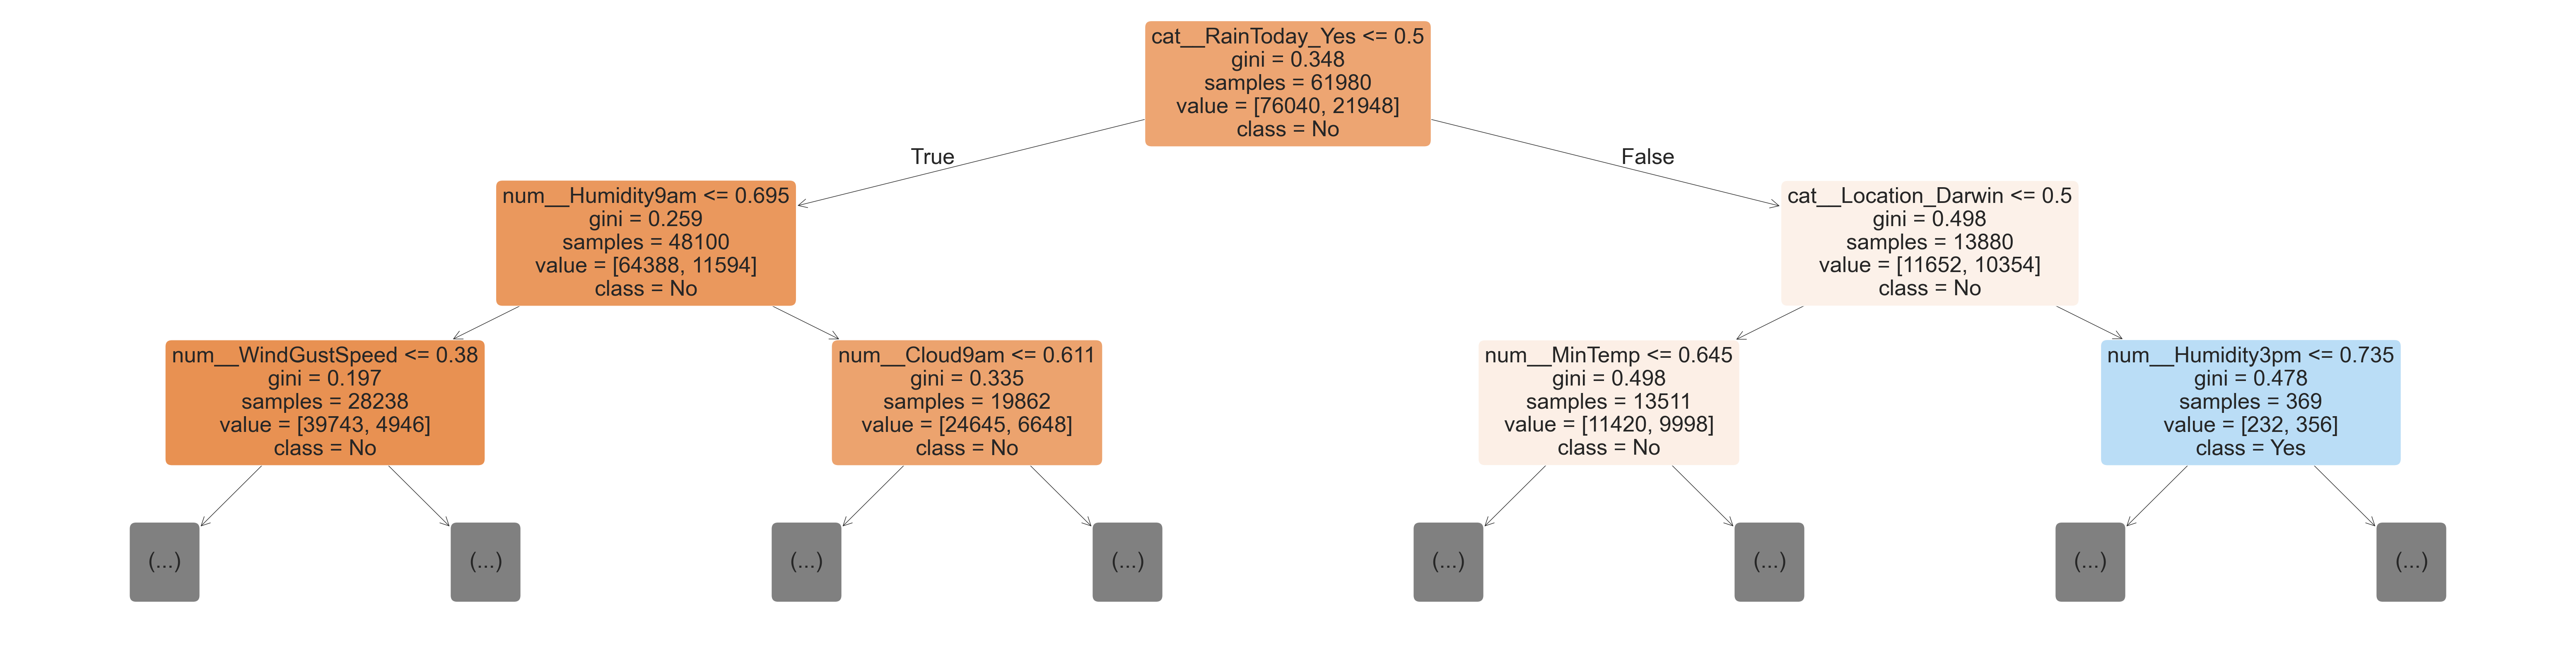

In [113]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [114]:
len(model.estimators_)

100

> **EXERCISE**: Verify that none of the individual decision trees have a better validation accuracy than the random forest. 

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [115]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [116]:
importance_df.head(10)

,feature,importance
9,num__Humidity3pm,0.131487
4,num__Sunshine,0.059760
11,num__Pressure3pm,0.053526
10,num__Pressure9am,0.049247
8,num__Humidity9am,0.048636
5,num__WindGustSpeed,0.048084
15,num__Temp3pm,0.046642
2,num__Rainfall,0.046375
0,num__MinTemp,0.042962
1,num__MaxTemp,0.042010


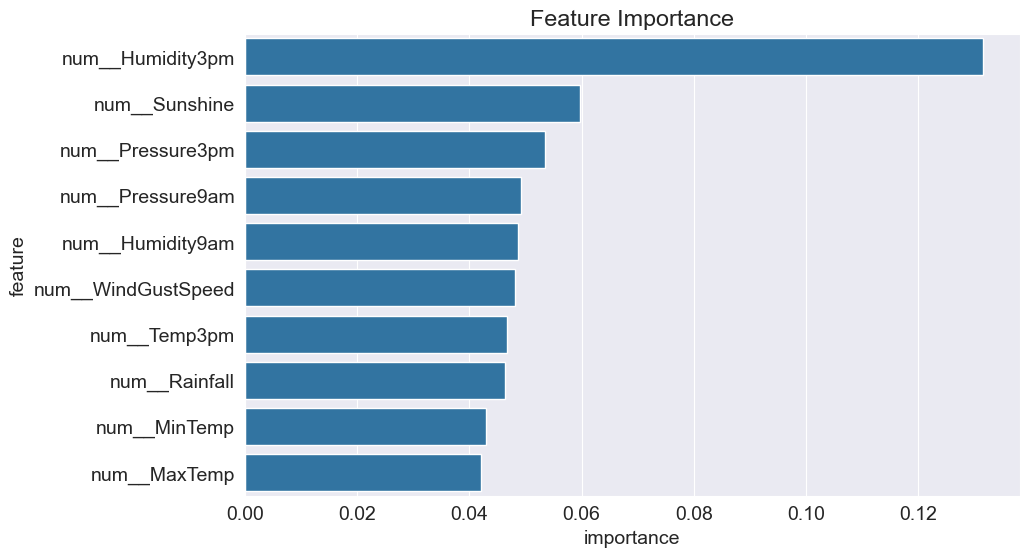

In [117]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

## Hyperparameter Tuning with Random Forests



Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [118]:
?RandomForestClassifier

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the 

Let's create a base model with which we can compare models with tuned hyperparameters.

In [24]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train)
base_accs = base_model.score(X_train, y_train), base_model.score(X_val, y_val)
base_accs

(0.9999693840062048, 0.8567499561121189)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [176]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_val, y_val)

(0.9873657998938645, 0.8445783837556323)

In [125]:
base_accs

(0.9999693840062048, 0.8567499561121189)

**500 estimators**

In [177]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_val, y_val)

(0.9999795893374699, 0.8581543683070981)

In [178]:
base_accs

(0.9999693840062048, 0.8567499561121189)

> **EXERCISE**: Vary the value of `n_estimators` and plot the graph between training error and validation error. What is the optimal value of `n_estimators`?

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [26]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
    return model.score(X_train, y_train), model.score(X_val, y_val)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [180]:
test_params(max_depth=5)

(0.8218659427685022, 0.8260284393469484)

In [132]:
test_params(max_depth=26)

(0.9822529289300731, 0.8576862309087717)

In [133]:
test_params(max_leaf_nodes=2**5)

(0.832030452708495, 0.8352156357891041)

In [134]:
test_params(max_leaf_nodes=2**20)

(0.9999693840062048, 0.8554040610919305)

In [135]:
base_accs # no max depth or max leaf nodes

(0.9999693840062048, 0.8567499561121189)

In [27]:
from tqdm.notebook import tqdm
def test_multi_params(paramss:list[dict]):
    results = []
    for params in tqdm(paramss):
        model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
        results.append([params, model.score(X_train, y_train), model.score(X_val, y_val)])
    return pd.DataFrame(results, columns=["params", "train_acc", "val_acc"])


In [ ]:

    
test_multi_params([{"max_depth":5},
                   {"max_depth":26},
                   {"max_leaf_nodes":2**5},
                   {"max_leaf_nodes":2**20},
                  ])

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

> **EXERCISE**: Vary the value of `max_depth` and plot the graph between training error and validation error. What is the optimal value of `max_depth`? Do the same for `max_leaf_nodes`.

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [187]:
print(base_accs)
test_multi_params([{"max_features":'log2'},
                   {"max_features":3},
                   {"max_features":6},
                   ])

(0.9999693840062048, 0.8567499561121189)


  0%|          | 0/3 [00:00<?, ?it/s]

,params,train_acc,val_acc
0,{'max_features': 'log2'},0.99998,0.856691
1,{'max_features': 3},0.99998,0.852888
2,{'max_features': 6},0.99998,0.856691


> **EXERCISE**: Find the optimal values of `max_features` for this dataset.

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [188]:
print(base_accs)
test_multi_params([{"min_samples_split":3, "min_samples_leaf":2},
                   {"min_samples_split":100, "min_samples_leaf":60},
                   ])

(0.9999693840062048, 0.8567499561121189)


  0%|          | 0/2 [00:00<?, ?it/s]

,params,train_acc,val_acc
0,"{'min_samples_split': 3, 'min_samples_leaf': 2}",0.961914,0.856808
1,"{'min_samples_split': 100, 'min_samples_leaf':...",0.851482,0.846100


> **EXERCISE**: Find the optimal values of `min_samples_split` and `min_samples_leaf`.

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.



In [189]:
print(base_accs)
test_multi_params([{"min_impurity_decrease":1e-7},
                   {"min_impurity_decrease":1e-2},
                   ])

(0.9999693840062048, 0.8567499561121189)


  0%|          | 0/2 [00:00<?, ?it/s]

,params,train_acc,val_acc
0,{'min_impurity_decrease': 1e-07},0.999694,0.857979
1,{'min_impurity_decrease': 0.01},0.777544,0.790626


> **EXERCISE**: Find the optimal values of `min_impurity_decrease` for this dataset.

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [28]:
print(base_accs)
test_params(bootstrap=False)

(0.9999693840062048, 0.8567499561121189)


(0.9999795893374699, 0.8580373339575166)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [194]:
test_params(max_samples=0.9)

(0.9999693840062048, 0.8567499561121189)


(0.9998265093684942, 0.8569255076364913)

Learn more about bootstrapping here: https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

### `class_weight`

In [150]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [32]:
print(base_accs)
test_multi_params([{"class_weight":'balanced'},
                   {"class_weight":{'No': 1, 'Yes': 3}},
                   ])

(0.9999693840062048, 0.8567499561121189)


  0%|          | 0/2 [00:00<?, ?it/s]

,params,train_acc,val_acc
0,{'class_weight': 'balanced'},0.999969,0.854760
1,"{'class_weight': {'No': 1, 'Yes': 3}}",0.999969,0.855638


> **EXERCISE**: Find the optimal value of `class_weight` for this dataset.

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [195]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=7,
                               max_depth=30, 
                               class_weight={'No': 1, 'Yes': 1.5})
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [170]:
model.score(X_train, y_train), model.score(X_val, y_val)

(0.9095807649916317, 0.8539411317221605)

In [171]:
base_accs

(0.9999693840062048, 0.8567499561121189)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

### Strategy for Tuning Hyperparameters

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. n_estimators

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using an experiment tracking sheet: https://bit.ly/mltrackingsheet


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.


Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter

> **EXERCISE**: Experiment with the hyperparameters of the random forest classifier, and try to maximize the validation accuracy.

Finally, let's also compute the accuracy of our model on the test set.

In [173]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, model.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.96      0.90     19885
         Yes       0.76      0.44      0.56      5825

    accuracy                           0.84     25710
   macro avg       0.81      0.70      0.73     25710
weighted avg       0.83      0.84      0.83     25710



Notice that the test accuracy is lower

## Making Predictions on New Inputs



Let's define a helper function to make predictions on new inputs.

In [38]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    X_input = preprocessor.transform(input_df)
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [39]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [40]:
predict_input(model, new_input)

('Yes', 0.73)

> **EXERCISE**: Try changing the values in `new_input` and observe how the predictions and probabilities change. Try different values of location, temperature, humidity, pressure etc. Try to get an _intuitive feel_ of which columns have the greatest effect on the result of the model.

In [41]:
raw_df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

## Saving and Loading Trained Models



We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [140]:
import joblib

In [142]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

The object can be loaded back using `joblib.load`

In [ ]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [ ]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

## Summary and References



The following topics were covered in this tutorial:

- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting & hyperparameter tuning
- Making predictions on single inputs



We also introduced the following terms:

* Decision tree
* Random forest
* Overfitting
* Hyperparameter
* Hyperparameter tuning
* Ensembling
* Generalization
* Bootstrapping


Check out the following resources to learn more: 

- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
- https://www.kaggle.com/c/home-credit-default-risk/discussion/64821


## Revision Questions


1.	What is a decision tree model?
2.	What is <code>DecisionTreeClassifier()</code>?
3.	Can we use decision tree only for Classifier? 
4.	How can you visualize the decision tree?
5.	What is <code>max_depth</code> in decision tree?
6.	What is gini index?
7.	What is feature importance?
8.	What is overfitting? What could be the reason for overfitting?
9.	What is hyperparameter tuning?
10.	What is one way to control the complexity of the decision tree?
11.	What is a random forest model?
12.	What is <code>RandomForestClassifier()</code>?
13.	What is <code>model.score()</code>?
14.	What is generalization?
15.	What is ensembling?
16.	What is <code>n_estimators</code> in hyperparameter tuning of random forests?
17.	What is underfitting?
18.	What does <code>max_features</code> parameter do?
19.	What are some features that help in controlling the threshold for splitting nodes in decision tree?
20.	What is bootstrapping? What is <code>max_samples</code> parameter in bootstrapping?
21.	What is <code>class_weight</code> parameter?
22.	You may or may not a see a significant improvement in the accuracy score with hyperparameter tuning. What could be the possible reasons for that?